# Introduction  

This is a multi-class classification problem, meaning that there are more than two classes to be predicted, in fact there are three flower species. This is an important type of problem on which to practice with neural networks because the three class values require specialized handling.

# 2. Import Classes and Functions

We can begin by importing all of the classes and functions we will need in this tutorial.

This includes both the functionality we require from Keras, but also data loading from pandas as well as data preparation and model evaluation from scikit-learn.

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from joblib import dump, load
import pandas as pd 
import numpy as np 

# 3. Train and save model  

## 3.1 Load our data  


In [2]:
df = pd.read_csv('data/customertrain.csv')
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


We can see that we have 8068 training examples, but we do have some things to sort out:  

- We will neeed to deal with all the null values in some of the features and we will auto generate values
- Our output variables 'Y' also has nulls, we will remove those rows

In [4]:
def prepareY(df):
    # Drop rows with no Output values
    df.dropna(subset=['Var_1'], inplace=True)

    # extract Y and drop from dataframe
    Y = df["Var_1"]

    # encode class values as integers
    yencoder = LabelEncoder()
    yencoder.fit(Y)
    dump(yencoder,"models/yencoder.joblib")
    # np.save('models/y_classes.npy', yencoder.classes_) # save for later
    return yencoder.transform(Y)
    # encoded_Y = yencoder.transform(Y)

    # # convert integers to one hot encoded)
    # return np_utils.to_categorical(encoded_Y), encoded_Y


y = prepareY(df)
df = df.drop(["Var_1"], axis=1)
pd.DataFrame(y).head()

,0
0,3
1,3
2,5
3,5
4,5


## 3.2 Prepare our features  

## fillmissing  

An important part of regression is understanding which features are missing. We can choose to ignore all rows with missing values, or fill them in with either mode, median or mode.  

- Mode = most common value
- Median = middle value
- Mean = average

This is a handy function you can call which will fill in the missing features by your desired method. We will choose to fill in values with the average.  

## prepareFeatures  

We need to do a few things to our features, so we can work with them a little easier.  

- Lets convert our string fields to numbers
- Call fillmissing to fill in any missing values in our features.  
- Use MinMaxScaler to normalise our numbers so thay have mean of zero with a deviation of 1.  

In [5]:
def fillmissing(df, feature, method):
    """Fills in missing values in features so we do not loose the rows

      Parameters:
      df (DataFrame): The dataframe with features
      feature (string): The feature to fill in
      method (string): replace the nill with either mode, median or default to mean
    """  
    if method == "mode":
      df[feature] = df[feature].fillna(df[feature].mode()[0])
    elif method == "median":
      df[feature] = df[feature].fillna(df[feature].median())
    else:
      df[feature] = df[feature].fillna(df[feature].mean())

def prepareFeatures(df):
    """Prepares feature for ML

      Parameters:
      df (DataFrame): The dataframe with features

      Returns:
      X (nparray): a normalised array of all features
    """  
    # Encode string features to numerics
    columns = df.select_dtypes(include=['object']).columns
    # columns = ["Gender","Ever_Married","Graduated","Profession","Spending_Score"]
    for feature in columns:
        le = LabelEncoder()
        df[feature] = le.fit_transform(df[feature])
        # np.save('models/'+feature+'_classes.npy', le.classes_) # save for later
        dump(le, 'models/'+feature+'.joblib') 

    # fill in missing features with mean values
    features_missing = df.columns[df.isna().any()]
    for feature in features_missing:
      fillmissing(df, feature= feature, method= "mean")    

    scaler = MinMaxScaler(feature_range=(-1, 1))
    X = scaler.fit_transform(df)
    dump(scaler, "models/featurescaler.joblib") 
    # np.save('models/featurescaler.npy', le.classes_) # save for later
    return X, df

df = df.drop(["Segmentation","ID"], axis=1) # These fields not features we can use
X, df = prepareFeatures(df)
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7
0,1.0,-1.0,-0.887324,-1.0,0.111111,-0.857143,1.0,-0.25
1,-1.0,0.0,-0.436620,0.0,-0.555556,-0.622480,-1.0,-0.50
2,-1.0,0.0,0.380282,0.0,-0.555556,-0.857143,1.0,-1.00
3,1.0,0.0,0.380282,0.0,0.555556,-1.000000,0.0,-0.75
4,-1.0,0.0,-0.380282,0.0,-0.333333,-0.622480,0.0,0.25


After funning below, you should see 7992 with non-null values and all should be float64.

In [6]:
pd.DataFrame(X).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7992 entries, 0 to 7991
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       7992 non-null   float64
 1   1       7992 non-null   float64
 2   2       7992 non-null   float64
 3   3       7992 non-null   float64
 4   4       7992 non-null   float64
 5   5       7992 non-null   float64
 6   6       7992 non-null   float64
 7   7       7992 non-null   float64
dtypes: float64(8)
memory usage: 499.6 KB


# 3.3 Split train and test data  

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 3.4 Hot Encoding Y

The output variable contains six different string values.

When modeling multi-class classification problems using neural networks, it is good practice to reshape the output attribute from a vector that contains values for each class value to be a matrix with a boolean for each class value and whether or not a given instance has that class value or not.

This is called `one hot encoding` or creating dummy variables from a categorical variable.

For example, in this problem six class values are [1,2,3,4,5,6]. We can turn this into a one-hot encoded binary matrix for each data instance that would look as follows:    
  
![onehot](./images/y_one_hot.png)

In [8]:
yhot = np_utils.to_categorical(y)
yhot_train = np_utils.to_categorical(y_train)
yhot_test = np_utils.to_categorical(y_test)

# 3.5 Define The Neural Network Model

There is a KerasClassifier class in Keras that can be used as an Estimator in scikit-learn, the base type of model in the library. The KerasClassifier takes the name of a function as an argument. This function must return the constructed neural network model, ready for training.

Below is a function that will create a baseline neural network for the customer classification problem. It creates a simple fully connected network with one hidden layer that contains 8 neurons.

The hidden layer uses a rectifier activation function which is a good practice. Because we used a one-hot encoding for our customer dataset, the output layer must create 6 output values, one for each class. The output value with the largest value will be taken as the class predicted by the model.

So, now you are asking “What are reasonable numbers to set these to?”  

- Input layer = set to the size of the features, but add a bias neuron (ie. 9)
- Hidden layers = set to input_layer * 2 (ie. 18)
- Output layer = set to the size of the labels of Y. In our case, this is 7 categories

The network topology of this simple one-layer neural network can be summarized as:

```
9 inputs -> [18 hidden nodes] -> 7 outputs
```

Note that we use a **softmax** activation function in the output layer. This is to ensure the output values are in the range of 0 and 1 and may be used as predicted probabilities.

Finally, the network uses the efficient **Adam gradient descent optimization algorithm** with a logarithmic loss function, which is called **categorical_crossentropy** in Keras.

In [9]:
# define baseline model
def baseline_model():
	# create model
	model = Sequential()
	# Rectified Linear Unit Activation Function
	model.add(Dense(16, input_dim=8, activation='relu'))
	model.add(Dense(16, activation = 'relu'))
	# Softmax for multi-class classification
	model.add(Dense(7, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

We can now create our KerasClassifier for use in scikit-learn.

We can also pass arguments in the construction of the KerasClassifier class that will be passed on to the fit() function internally used to train the neural network. Here, we pass the number of epochs as 200 and batch size as 5 to use when training the model. Debugging is also turned off when training by setting verbose to 0.  

Advantages of using a batch size < number of all samples:  

- It requires less memory. Since you train the network using fewer samples, the overall training procedure requires less memory. That's especially important if you are not able to fit the whole dataset in your machine's memory.  
- Typically networks train faster with mini-batches. That's because we update the weights after each propagation.  

In [10]:
# model = baseline_model()
cmodel = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=100, verbose=0)

# 3.6 Evaluate The Model with k-Fold Cross Validation

Now, lets evaluate the neural network model on our training data.

The scikit-learn evaluates models using various techniques. The gold standard for evaluating machine learning models is **k-fold cross validation**.

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.

The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. When a specific value for k is chosen, it may be used in place of k in the reference to the model, such as k=10 becoming 10-fold cross-validation.

It is a popular method because it is simple to understand and because it generally results in a less biased or less optimistic estimate of the model skill than other methods, such as a simple train/test split.

The general procedure is as follows:

1. Shuffle the dataset randomly.  
2. Split the dataset into k groups  
3. For each unique group:  
3.1 Take the group as a hold out or test data set  
3.2 Take the remaining groups as a training data set  
3.3 Fit a model on the training set and evaluate it on the test set  
3.4 Retain the evaluation score and discard the model  
4. Summarize the skill of the model using the sample of model evaluation scores  

Lets define the model evaluation procedure. Here, we set  

- The number of folds to be 10 (a good default) 
- Shuffle the data before partitioning it. 

In [11]:
kfold = KFold(n_splits=10, shuffle=True)

Now we can evaluate our model (estimator) on our dataset (X and hot_y) using a 10-fold cross-validation procedure (kfold).

Evaluating the model returns an object that describes the evaluation of the 10 constructed models for each of the splits of the dataset.

In [12]:
result = cross_val_score(cmodel, X, yhot, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (result.mean()*100, result.std()*100))

2021-08-22 18:21:30.409109: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-22 18:21:30.518411: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Baseline: 66.13% (1.57%)


# 3.7 Compile and evaluate model on test data  

In [13]:
model = baseline_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, yhot_train, validation_split=0.33,
                    epochs=200, batch_size=100, verbose=0)

# 3.8 Plot the learning curve  

The plots are provided below. The history for the validation dataset is labeled test by convention as it is indeed a test dataset for the model.

From the plot of accuracy we can see that the model could probably be trained a little more as the trend for accuracy on both datasets is still rising for the last few epochs. We can also see that the model has not yet over-learned the training dataset, showing comparable skill on both datasets.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


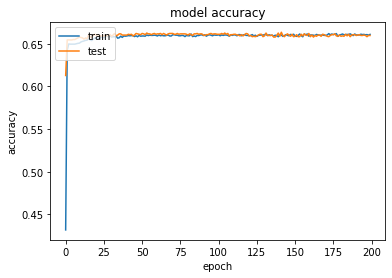

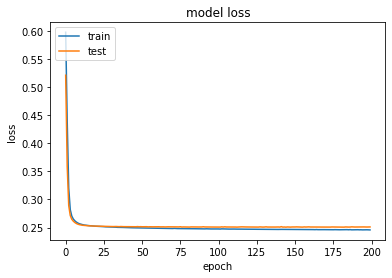

In [14]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
# evaluate the keras model
_, accuracy = model.evaluate(X_test, yhot_test)
print('Accuracy from evaluate: %.2f' % (accuracy*100))

50/50 [==============================] - 0s 780us/step - loss: 0.2447 - accuracy: 0.6836
Accuracy from evaluate: 68.36


In [16]:
predict_x = model.predict(X_test)
pred = np.argmax(predict_x, axis=1)
print(f'Prediction Accuracy: {(pred == y_test).mean() * 100:f}')

Prediction Accuracy: 68.355222


# 3.9 Save the model  

The model is then converted to JSON format and written to model.json in the local directory. The network weights are written to model.h5 in the local directory.  

In [17]:
model_json = model.to_json()
with open("models/customermodel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# 2 Reload models from disk and predict  

## 2.1 Look at our files

The model and weight data is loaded from the saved files and a new model is created. It is important to compile the loaded model before it is used. This is so that predictions made using the model can use the appropriate efficient computation from the Keras backend.

The model is evaluated in the same way printing the same evaluation score.  

In [18]:
ls -l models

total 128
-rw-r--r--  1 shaunenslin  staff   515 Aug 22 18:21 Ever_Married.joblib
-rw-r--r--  1 shaunenslin  staff   310 Aug 22 17:57 Ever_Married_classes.npy
-rw-r--r--  1 shaunenslin  staff   511 Aug 22 18:21 Gender.joblib
-rw-r--r--  1 shaunenslin  staff   306 Aug 22 17:57 Gender_classes.npy
-rw-r--r--  1 shaunenslin  staff   515 Aug 22 18:21 Graduated.joblib
-rw-r--r--  1 shaunenslin  staff   310 Aug 22 17:57 Graduated_classes.npy
-rw-r--r--  1 shaunenslin  staff   635 Aug 22 18:21 Profession.joblib
-rw-r--r--  1 shaunenslin  staff   430 Aug 22 17:57 Profession_classes.npy
-rw-r--r--  1 shaunenslin  staff   522 Aug 22 18:21 Spending_Score.joblib
-rw-r--r--  1 shaunenslin  staff   317 Aug 22 17:57 Spending_Score_classes.npy
-rw-r--r--  1 shaunenslin  staff  1591 Aug 22 18:23 customermodel.json
-rw-r--r--  1 shaunenslin  staff   896 Aug 22 18:21 featurescaler.joblib
-rw-r--r--  1 shaunenslin  staff   317 Aug 22 17:14 featurescaler.npy
-rw-r--r--  1 shaunenslin  staff   896 Aug 22 17:

## 2.2 Reload the model  

We will reload our data, simulating the vent where we maay be wanting to run a prediction a day or two later.

In [19]:
from keras.models import model_from_json

# load json and create model
json_file = open('modelcustomer.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
# loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Loaded model from disk


## 2.4 Reload data  

Reload our training data, but take a 10% random sample  

In [32]:
df = pd.read_csv('data/customertrain.csv')
df = df.sample(frac=0.10)
df.dropna(inplace=True)
df = df.drop(["Segmentation","ID"], axis=1) # These fields not features we can use
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 660 entries, 806 to 4067
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           660 non-null    object 
 1   Ever_Married     660 non-null    object 
 2   Age              660 non-null    int64  
 3   Graduated        660 non-null    object 
 4   Profession       660 non-null    object 
 5   Work_Experience  660 non-null    float64
 6   Spending_Score   660 non-null    object 
 7   Family_Size      660 non-null    float64
 8   Var_1            660 non-null    object 
dtypes: float64(2), int64(1), object(6)
memory usage: 51.6+ KB


In [28]:
df.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
5505,Male,Yes,58,Yes,Doctor,1.0,High,2.0,Cat_6
2527,Male,Yes,35,Yes,Artist,0.0,Average,2.0,Cat_6
7638,Female,Yes,86,Yes,Lawyer,0.0,High,2.0,Cat_6
1330,Female,Yes,88,Yes,Lawyer,1.0,High,2.0,Cat_6
2133,Female,Yes,72,Yes,Artist,3.0,Average,3.0,Cat_6


Now, when we realod Y, we first want to load our original encoder. Naturally, we cannot have new categories, else we will get an error at this point.

In [33]:
def prepareYreload(df):
    # yencoder = LabelEncoder()
    # yencoder.classes_ = np.load('models/y_classes.npy', allow_pickle=True) # reload saved class from training
    yencoder = load("models/yencoder.joblib")
    return yencoder.transform(df["Var_1"])

y = prepareYreload(df)
df = df.drop(["Var_1"], axis=1)
pd.DataFrame(y)

,0
0,5
1,5
2,5
3,2
4,5
...,...
655,5
656,1
657,5
658,5


In [34]:
def prepareFeaturesReload(df):
    """Prepares feature for predictions, this time, use classes saved for labelencoder and scaler

      Parameters:
      df (DataFrame): The dataframe with features

      Returns:
      X (nparray): a normalised array of all features
    """  
    # Encode string features to numerics
    columns = df.select_dtypes(include=['object']).columns
    print(columns)
    for feature in columns:
      print('models/'+feature+'.joblib')
      fencoder = load('models/'+feature+'.joblib')
      print(fencoder.classes_)
      df[feature] = fencoder.fit(df[feature])
        # le = LabelEncoder()
        # le.classes_ = np.load('models/'+feature+'_classes.npy', allow_pickle=True) # reload saved class from training
        # df[feature] = le.fit(df[feature])

    # fill in missing features with mean values
    features_missing = df.columns[df.isna().any()]
    for feature in features_missing:
      fillmissing(df, feature= feature, method= "mean")    

X, df = prepareFeaturesReload(df)
pd.DataFrame(X).head()

Index(['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score'], dtype='object')
Gender
['Female' 'Male']
Ever_Married
['No' 'Yes' nan]
Graduated
['No' 'Yes' nan]
Profession
['Artist' 'Doctor' 'Engineer' 'Entertainment' 'Executive' 'Healthcare'
 'Homemaker' 'Lawyer' 'Marketing' nan]
Spending_Score
['Average' 'High' 'Low']


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
predict_x = loaded_model.predict(X)
pred = np.argmax(predict_x, axis=1)
print(f'Prediction Accuracy: {(pred == Y).mean() * 100:f}')

# 7. Conclusion

In this post you discovered how to develop and evaluate a neural network using the Keras Python library for deep learning.
You learned:  
  
- How to load data and make it available to Keras.  
- How to prepare multi-class classification data for modeling using one hot encoding.  
- How to use Keras neural network models with scikit-learn.  
- How to define a neural network using Keras for multi-class classification.  
- How to evaluate a Keras neural network model using scikit-learn with k-fold cross validation  

Some interesting things to observe:  

With batch size of 5, we end up with 66.10% accuracy:  

- Without normalising, it takes 3200 seconds for cross_val_score  
- With normalising, it takes 1422 seconds for cross_val_score  

With batch size of 100, we end up with an accuracy of 66.38%:  

- Without normalising, it takes 83 seconds for cross_val_score  
- With normalising, it takes 78 seconds for cross_val_score  